# 02. 시계열 시각화 

데이터 분석 작업에서 가장 먼저 해야하는 것은 데이터를 그래프으로 나타내는 것입니다. 그래프는 패턴, 특이한 관측값, 시간에 따른 변화, 변수 사이의 관계 등의 데이터의 많은 특징을 눈으로 볼 수 있게 해줍니다. 데이터를 그림으로 나타낸 그래프에서 보이는 특징은 사용할 예측 기법에 반드시 포함되어야 합니다. 데이터의 종류가 어떤 예측 기법을 사용할 지 결정하기도 하고, 어떤 그래프가 적절한지도 알려줍니다. 하지만 그래프를 그리기 전에, R에서 그릴 시계열을 준비해야 합니다.

In [4]:
library(patchwork)
library(tidyverse)
library(fpp3)
source('setup.R')

In [5]:
global_economy <- global_economy %>%
  select(Year, Country, GDP, Imports, Exports, Population)

tourism <- tourism %>%
  mutate(
    State = recode(State,
      "Australian Capital Territory" = "ACT",
      "New South Wales" = "NSW",
      "Northern Territory" = "NT",
      "Queensland" = "QLD",
      "South Australia" = "SA",
      "Tasmania" = "TAS",
      "Victoria" = "VIC",
      "Western Australia" = "WA"
    )
  )

<br>

## 02.01 시계열 객체

시계열이란 각 숫자가 기록된 시간에 관한 정보가 있는 숫자들의 목록으로 생각할 수 있습니다.

<br>

#### `ts()` : ts객체로 변환

- 연간 데이터 $\rightarrow$ `frequency = 1`

In [6]:
(y <- ts(c(123,39,78,52,110), start=2012, frequency = 1))

A Time Series:
[1] 123  39  78  52 110

- 월간 데이터 $\rightarrow$ `frequency = 12`

In [7]:
(y <- ts(c(123,39,78,52,110), start=2003, frequency=12))

,Jan,Feb,Mar,Apr,May
2003,123,39,78,52,110


<br>

### 시계열의 빈도


실제로 1년은 52주가 아니라, 4년마다의 윤년을 고려하여 평균적으로 365.25/7 = 52.18입니다. 하지만 ts 객체를 이용하는 대부분의 함수는 정수 빈도를 필요로 합니다.

**관측값의 빈도가 1주일에 한 번보다 클 때는, 빈도(frequency)를 다루는 한 가지 이상의 방법이 있습니다**

```
* 일별 관측값으로 구성된 데이터에는 주별 계절성(빈도=7)
* 연간 계절성(빈도=365.25)
* 1분마다 관측된 데이터에는 시간별 계절성(빈도=60)
* 일별 계절성(빈도=24x60=1440)
* 주별 계절성(빈도=24x60x7=10080)
* 연간 계절성(24x60x365.25=525960)
```

**ts 객체를 사용하고 싶다면, 이 중에서 어떤 것이 가장 중요한지 결정해야합니다.**


11 장에서는 이러한 빈도 목록에서 하나를 고르지 않고 다중 계절성(multiple seasonality)을 다루는 방법을 살펴볼 것입니다.

<br>

## 02.02 시간 그래프

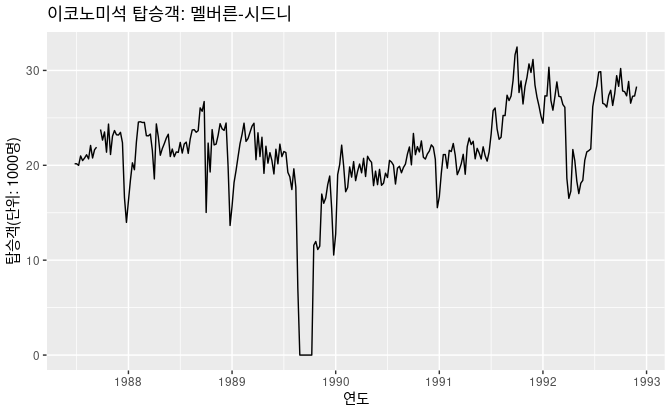

- 1989년은 파업으로 인하여 수송객이 없었던 기간입니다.
* 1992년은 수송객이 감소했던 기간인데, 이것은 일부 이코노미 좌석이 비지니스 좌석으로 교체되었기 때문입니다.
* 1991년 후반에는 수송객이 크게 증가했습니다.
* 휴가철 효과 때문에 매 연초에 일시적으로 크게 하락하는 몇몇 지점이 있습니다.
* 시계열의 수준(level; 여기에서는 평균값)에서 장기적인 변동(long-term fluctuation)을 살펴볼 수 있는데, 1987년에는 전반적으로 증가하는 추세, 1989년에는 감소 추세, 1990년과 1991년을 지나면서 다시 증가하는 추세를 확인할 수 있습니다.
* 관측값이 없는 기간도 일부 있습니다.

<br>

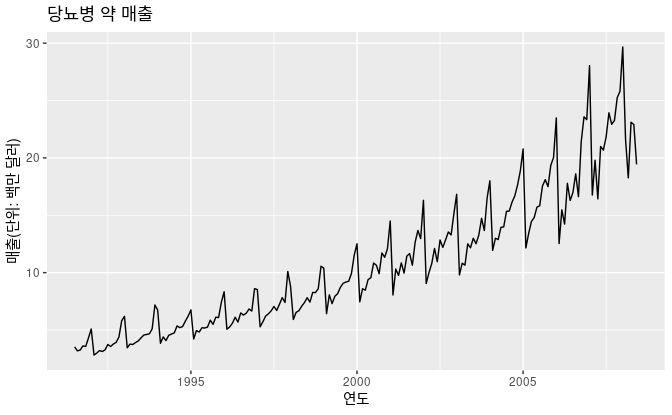

분명하게 증가하는 추세를 이 그림에서 확인할 수 있습니다. 시계열의 수준이 증가함에 따라 계절성 패턴의 크기 역시 뚜렷하게 증가합니다. 매년 연초마다 의약품 매출이 급감하는데, 이것은 환자들이 연말에 저렴하게 의약품을 비축할 수 있도록 하는 정부의 보조금 정책 때문입니다. 이 시계열을 이용하는 어떤 예측이라도 위에서 언급한 계절성 패턴과 더불어 변화의 추세가 느리다는 사실을 그 예측치 안에 담아내야 할 것입니다.

<br>

## 02.03. 시계열 패턴

이러한 시계열을 설명하려면, 지금까지 사용한 “추세(trend)”와 “계절성(seasonality)” 같은 단어를 좀 더 조심스럽게 정의해야 합니다.

#### 추세(trend)

데이터가 장기적으로 증가하거나 감소할 때, 추세(trend)가 존재합니다. 추세가 선형적일 필요는 없습니다. 때때로 어떤 추세가 증가에서 감소로 변화하는 경우에, 그것을 추세의 “방향이 변화했다”라고 언급할 것입니다. 그림 2.2의 당뇨병 약 매출 데이터에는 추세가 있습니다.

#### 계절성(seasonality)

해마다 어떤 특정한 때나 1주일마다 특정 요일에 나타나는 것 같은 계절성 요인이 시계열에 영향을 줄 때 계절성(seasonality) 패턴이 나타납니다. 계절성은 빈도의 형태로 나타나는데, 그 빈도는 항상 일정하며 알려져 있습니다. 위의 당뇨병 약 월별 매출액에는 계절성이 나타나는데, 이 계절성은 부분적으로 연말에 발생하는 약품 가격 변동에 의한 것입니다.

#### 주기성(cycle)

**고정된 빈도가 아닌 형태로 증가나 감소하는 모습을 보일 때 주기(cycle)가 나타납니다.** 보통 이러한 요동은 경제 상황 때문에 일어나고, 흔히 “경기 순환(business cycle)”과 관련 있습니다. 보통 이러한 요동의 지속기간은 적어도 2년 이상입니다.
많은 이들이 주기적인 패턴과 계절적인 패턴을 혼동하지만, 사실 둘은 정말 다릅니다. 일정한 빈도로 나타나지 않는 요동은 주기적입니다. 빈도가 변하지 않고 연중 어떤 시기와 연관되어 있다면 그 요동은 계절성입니다. 일반적으로, 주기들의 평균 길이는 계절성 패턴의 길이보다 길고, 주기의 크기는 계절적인 패턴의 크기보다 좀 더 변동성이 큰 경향이 있습니다.

많은 시계열에는 추세(trend), 계절성(seasonality), 주기(cycle)가 있습니다. 예측 기법을 고를 때, 먼저 데이터에서 나타나는 시계열 패턴을 살펴봐야할 것이고, 그 다음 적절하게 패턴을 잡아낼 수 있는 기법을 선택해야할 것입니다.

그림 2.3의 예제는 위의 성분의 서로 다른 조합을 보여줍니다.

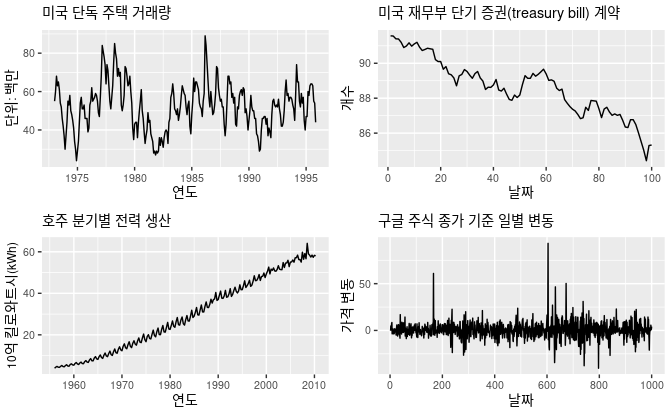

1. 월별 주택 매매 그래프에서(왼쪽 위) 매년 강한 계절성과 약 6–10년의 몇몇 강한 주기적인 패턴이 보입니다. 전체 기간에 걸쳐 데이터에 분명한 추세가 있지는 않습니다.
2. 미국 재무부 단기 증권 그래프는(오른쪽 위) 1981년 시카고 시장의 100 연속 거래일 데이터를 나타냅니다. 여기에는 계절성은 없지만, 아래로 내려가는 추세가 분명하게 있습니다. 아마도 훨씬 더 긴 시계열이 있었다면, 이 하향 추세가 실제로는 긴 주기의 한 부분이라는 것을 볼 수도 있었을 것이지만, 100 거래일만 놓고 볼 때, 추세가 있는 것 같습니다.
3. 호주 분기별 전기 생산량 그래프는(왼쪽 아래) 강한 계절성과 함께 강한 증가 추세를 나타냅니다. 여기에서 주기적인 행동이 보이지는 않습니다.
4. 구글(Google) 주식의 일별 종가(거래일 마지막 가격) 그래프(오른쪽 아래)에는 추세나 계절성 또는 주기적인 행동이 없습니다. 잘 예측할 수 있을 것 같지 않은 무작위적인 요동이 있고, 예측 모델을 만드는데 도움이 될 강한 패턴도 없습니다.

<br>

## 02.04. 계절성 그래프

계절성 그래프(seasonal plot)는 각 “계절(season)”에 대해 관측한 데이터를 나타낸다는 점만 제외하고는 시간 그래프와 비슷합니다. 아래 예제에서는 당뇨병 약 매출을 나타냅니다.


In [9]:
library(fpp)
data(a10)

a10

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1991,,,,,,,3.53,3.18,3.25,3.61,3.57,4.31
1992,5.09,2.81,2.99,3.20,3.13,3.27,3.74,3.56,3.78,3.92,4.39,5.81
1993,6.19,3.45,3.77,3.73,3.91,4.05,4.32,4.56,4.61,4.67,5.09,7.18
1994,6.73,3.84,4.39,4.08,4.54,4.65,4.75,5.35,5.20,5.30,5.77,6.20
1995,6.75,4.22,4.95,4.82,5.19,5.17,5.26,5.86,5.49,6.12,6.09,7.42
1996,8.33,5.07,5.26,5.60,6.11,5.69,6.49,6.30,6.47,6.83,6.65,8.61
1997,8.52,5.28,5.71,6.21,6.41,6.67,7.05,6.70,7.25,7.82,7.40,10.10
1998,8.80,5.92,6.53,6.68,7.06,7.38,7.81,7.43,8.28,8.26,8.60,10.56
1999,10.39,6.42,8.06,7.30,7.94,8.17,8.72,9.07,9.18,9.25,9.93,11.53
2000,12.51,7.46,8.59,8.47,9.39,9.56,10.83,10.64,9.91,11.71,11.34,12.08


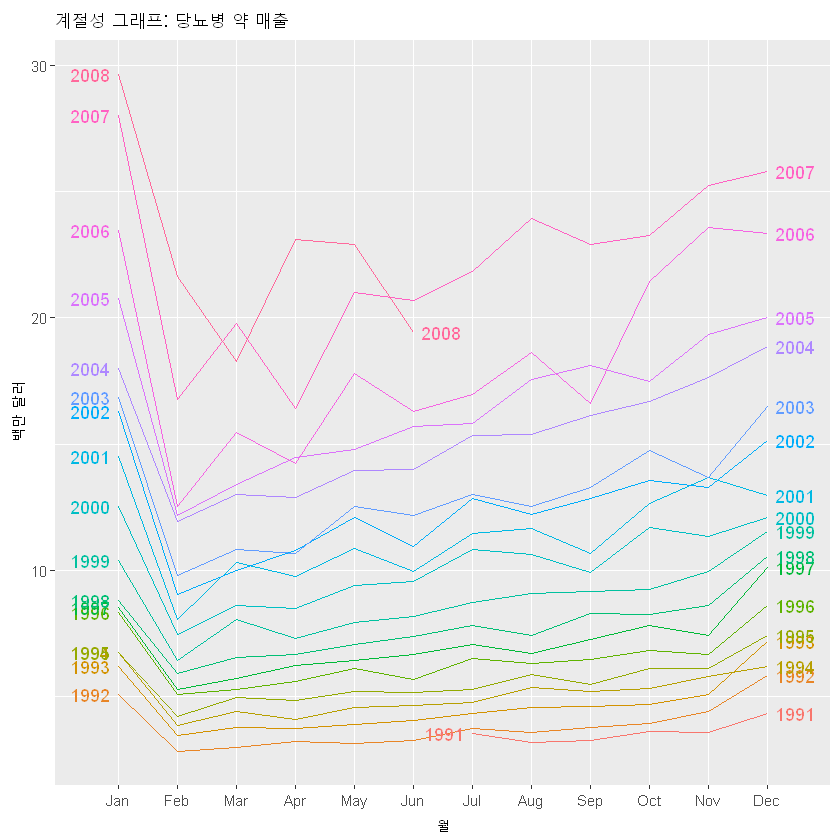

In [10]:
ggseasonplot(a10, year.labels = TRUE, year.labels.left = TRUE) +
  ylab("백만 달러") +
  xlab("월") +
  ggtitle("계절성 그래프: 당뇨병 약 매출")

이전에 보았던 것과 정확하게 같은 데이터입니다만, 여기에서는 데이터를 각 계절별로 포개었습니다. 계절성 그래프는 나타내려는 중요한 계절성 패턴을 더욱 분명하게 보여주고, 특별히 패턴 변화가 있는 연도를 찾아낼 때 쓸모가 있습니다.

이 경우에, 분명히 매년 1월에 매출이 크게 뜁니다. 실제로는, 소비자들이 연말에 사재기해서 나타나는 매출이 1~2주 이후까지 정부에 등록되지 않아서 나타나는 현상일 것입니다. 이 그래프는 2008년 3월 매출이 비정상적으로 작았다는 것도 보여줍니다(다른 연도에서는 2월과 3월 사이에 증가합니다). 2008년 6월 매출이 작은 이유는 당시에 데이터를 모을 때 제대로 집계하지 않았기 때문일 것입니다.

극좌표(polar coordinate)를 사용하여 계절성 그래프를 바꿔 나타내면 도움이 됩니다. 아래에서 볼 수 있는 것처럼, `polar=TRUE`로 두면, 수평축 대신 원형축으로 나타냅니다.

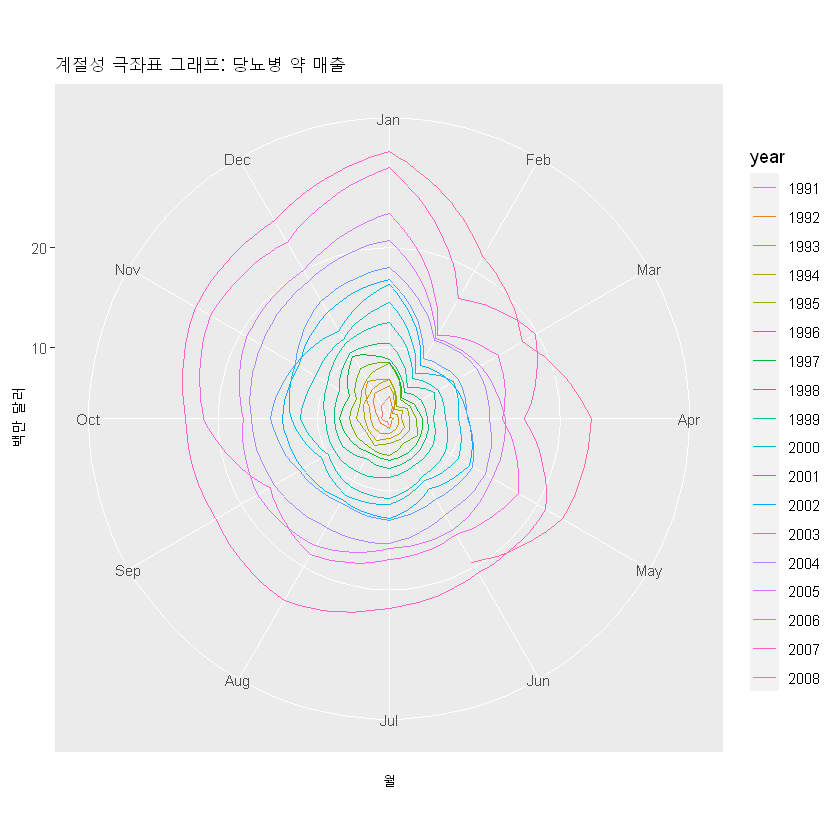

In [11]:
ggseasonplot(a10, polar = TRUE) +
  ylab("백만 달러") +
  xlab("월") +
  ggtitle("계절성 극좌표 그래프: 당뇨병 약 매출")

<br>

## 02.05. 계절성 부시계열 그래프

이러한 계절성 패턴을 강조하여 나타내는 또 다른 방법은 각 계절에 대한 데이터를 모아서 분리된 작은 시간 그래프로 나타내는 것입니다.

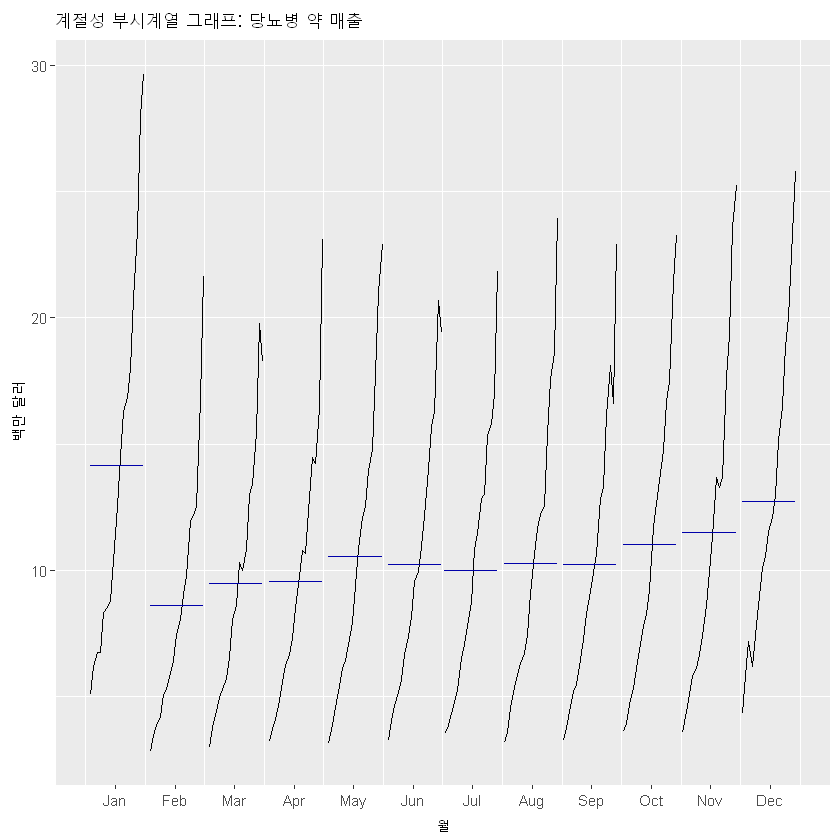

In [12]:
ggsubseriesplot(a10) +
  ylab("백만 달러") +
  xlab("월") +
  ggtitle("계절성 부시계열 그래프: 당뇨병 약 매출")

**수평선은 각 월에 대한 평균값을 의미합니다.** 이러한 형태의 그래프로 중요한 계절성 패턴을 분명하게 살펴볼 수 있고, 계절성이 시간에 따라 어떻게 변하는지도 볼 수 있습니다. 특정한 철에서 나타나는 변화를 확인할 때 특별히 쓸모가 있습니다. 이 예제에서, 이 그래프가 특별한 것을 보여주지는 않습니다만, 몇몇 경우에서 시간에 따른 계절성 변화를 나타낼 때 가장 쓸모 있는 방법입니다.

<br>

## 02.06. 산점도

지금까지 다룬 그래프는 각각의 시계열을 시각화 할 때 유용합니다. 시계열 사이의 관계를 살필 때도 쓸모가 있습니다.

그림 2.7은 두 개의 시계열을 보여줍니다. 2014년 호주 빅토리아 주의 30분 단위의 전력 수요(단위: 기가 와트)와 기온(단위: 섭씨)입니다. 온도값은 빅토리아 주의 가장 큰 도시인 멜버른에서 측정한 것이고, 수요값은 주 전체에 대한 값입니다.

In [18]:
library(fpp2)
as.data.frame(elecdemand) %>% head()

,Demand,WorkDay,Temperature
,<dbl>,<dbl>,<dbl>
1,3.91,0,18.2
2,3.67,0,17.9
3,3.50,0,17.6
4,3.34,0,16.8
5,3.20,0,16.3
6,3.10,0,16.6


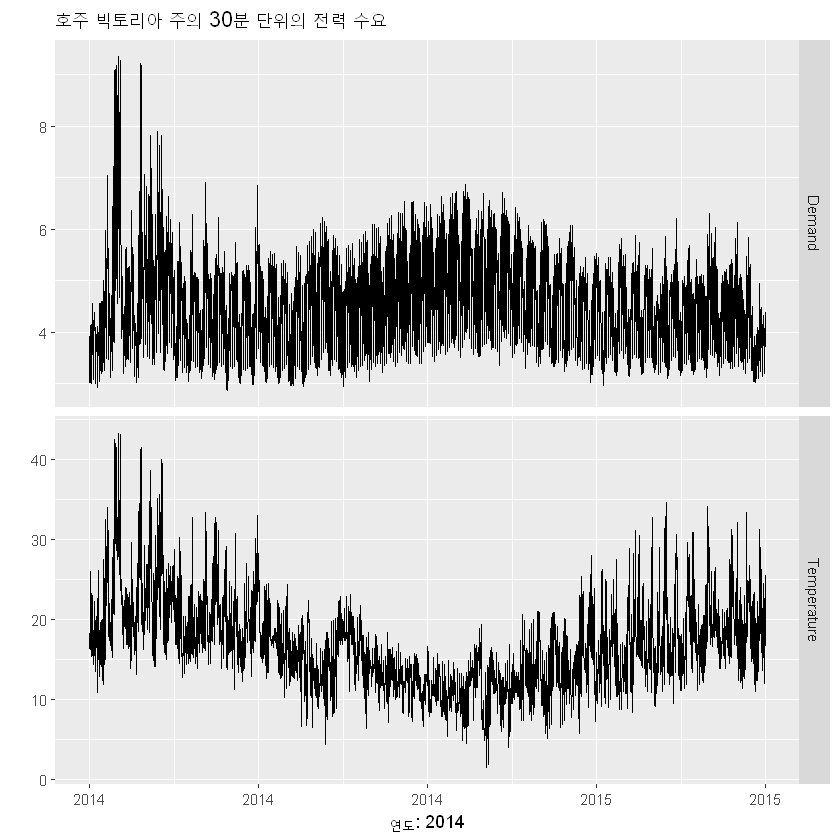

In [13]:
autoplot(elecdemand[,c("Demand","Temperature")], facets=TRUE) +
  xlab("연도: 2014") + ylab("") +
  ggtitle("호주 빅토리아 주의 30분 단위의 전력 수요")

한 시계열에 대해 또 다른 시계열을 그려서 수요과 기온 사이의 관계가 어떤지 살펴볼 수 있습니다.

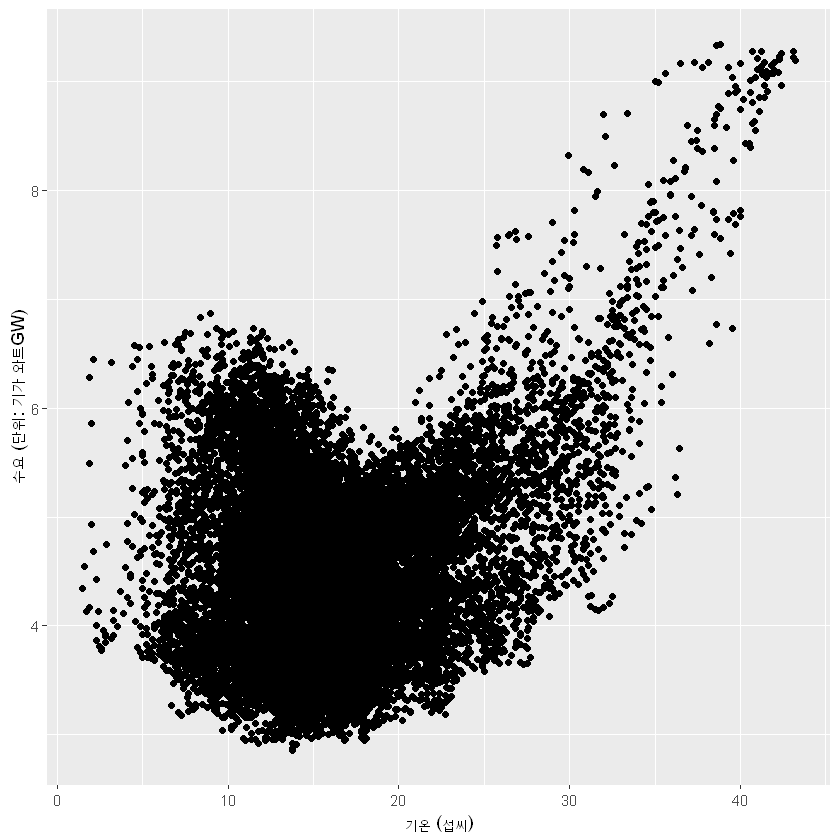

In [15]:
qplot(Temperature, Demand, data=as.data.frame(elecdemand)) +
  ylab("수요 (단위: 기가 와트GW)") + xlab("기온 (섭씨)")

이 산포도는 이러한 변수 사이의 관계를 시각화하는데 도움이 됩니다. 에어컨 효과 때문에 온도가 높을 때 수요가 높게 나타나는 것을 분명하게 확인할 수 있습니다. 하지만, 온도가 아주 낮을 때 수요가 증가하는 난방 효과도 나타납니다.

<br>

### 상관

상관계수(correlation coefficient)는 두 변수 사이의 관계의 강도를 측정할 때 흔히 계산하는 양입니다. 두 변수 $x$와 $y$사이의 상관계수는 다음과 같이 주어집니다.

$r = \frac{\sum (x_{t} - \bar{x})(y_{t}-\bar{y})}{\sqrt{\sum(x_{t}-\bar{x})^2}\sqrt{\sum(y_{t}-\bar{y})^2}}.$

$\rho$은 항상 -1과 1사이의 값을 갖고, 음수는 음의 관계를 양수는 양의 관계를 의미합니다. 그림 2.9 에서 그래프들은 다양한 수준의 상관(correlation)을 지닌 데이터들의 예시입니다.

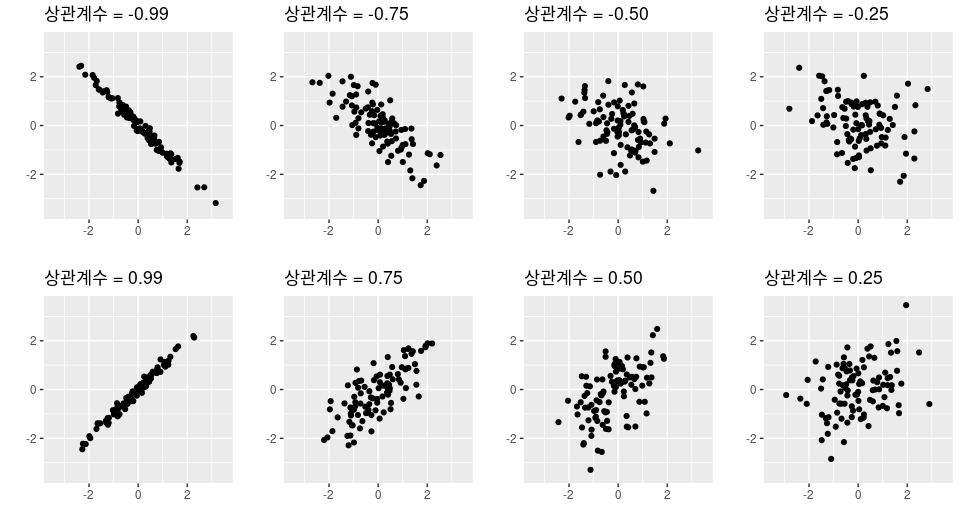

**상관계수(correlation coefficient)는 선형관계의 강도만 측정하기에, 종종 오해로 이어질 수 있습니다.** 예를 들면, 그림 2.8 에서 볼 수 있는 전력 수요와 기온 데이터에서 상관계수는 0.28입니다만, 비-선형 관계가 더 큽니다.

그림 2.10 에서 그래프는 모두 0.82의 상관계수를 갖습니다만, 나타나는 관계는 아주 다릅니다. 이를 통해 상관계수값에만 의존하지 말고 데이터를 그려서 살펴보는 것이 얼마나 중요한지 알 수 있습니다.

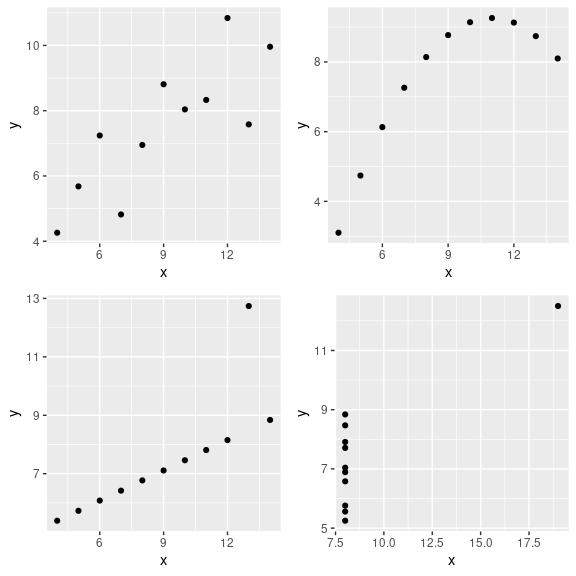

`Figure 2.10: 각각의 그래프에서 상관계수는 모두 0.82 입니다. 여기에서 사용한 데이터는 다음 논문에서 가져온 것입니다: FJ Anscombe (1973) Graphs in statistical analysis. American Statistician, 27, 17–21.`

<br>

### 산점도 행렬

몇 가지 후보가 될 만한 예측변수(predictor variable)가 있을 때, 각 변수를 다른 변수에 대해 나타내는 것이 도움이 됩니다. 그림 2.11 에 나타낸 5개의 시계열을 다뤄봅시다. 각 시계열은 호주 뉴 사우스 웨일즈 주(NSW)에 있는 5개 지역의 분기별 방문수를 나타냅니다.

In [22]:
as.data.frame(visnights)[1:5] %>% head()

,NSWMetro,NSWNthCo,NSWSthCo,NSWSthIn,NSWNthIn
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,9.05,8.57,5.82,2.68,2.98
2,6.96,7.12,2.47,3.01,3.48
3,6.87,4.72,1.93,3.33,3.01
4,7.15,6.27,2.80,2.42,3.76
5,7.96,9.49,4.85,3.22,3.79
6,6.54,5.40,2.76,2.43,3.40


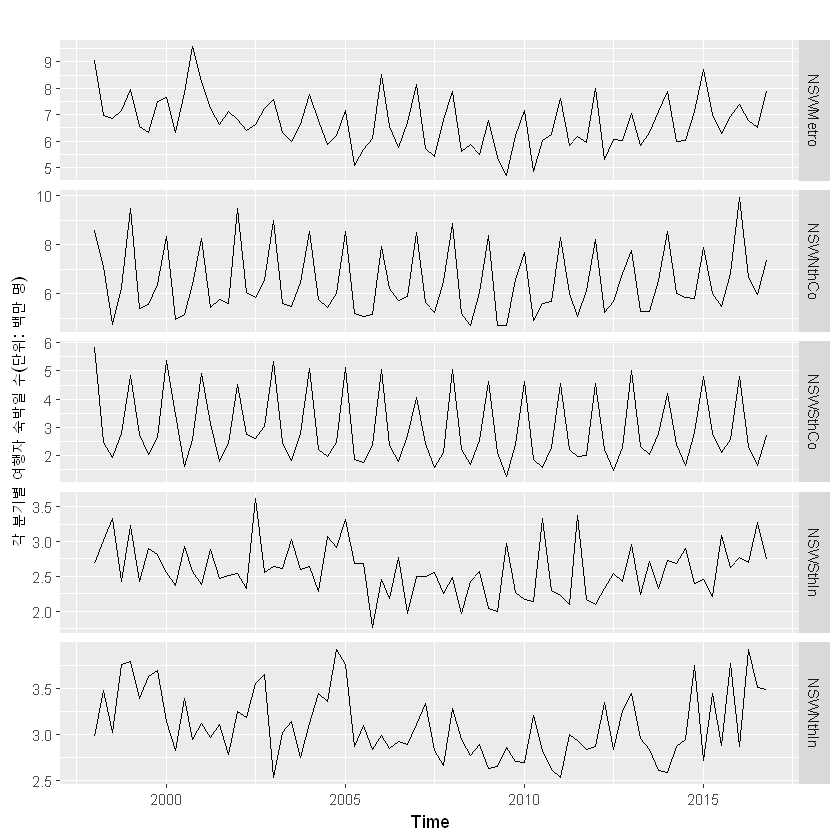

In [19]:
autoplot(visnights[,1:5], facets=TRUE) +
  ylab("각 분기별 여행자 숙박일 수(단위: 백만 명)")

이러한 5개의 시계열 사이의 관계를 살펴보기 위해, 각 시계열을 다른 시계열에 대해 나타내볼 수 있습니다. 이러한 그래프들은 그림 2.12 에 나타낸 것과 같이 산점도행렬(scatterplot matrix)로 늘어놓을 수 있습니다. (이 그래프를 그리기 위해서는 GGally 패키지가 설치되어있어야 합니다.)

<br>


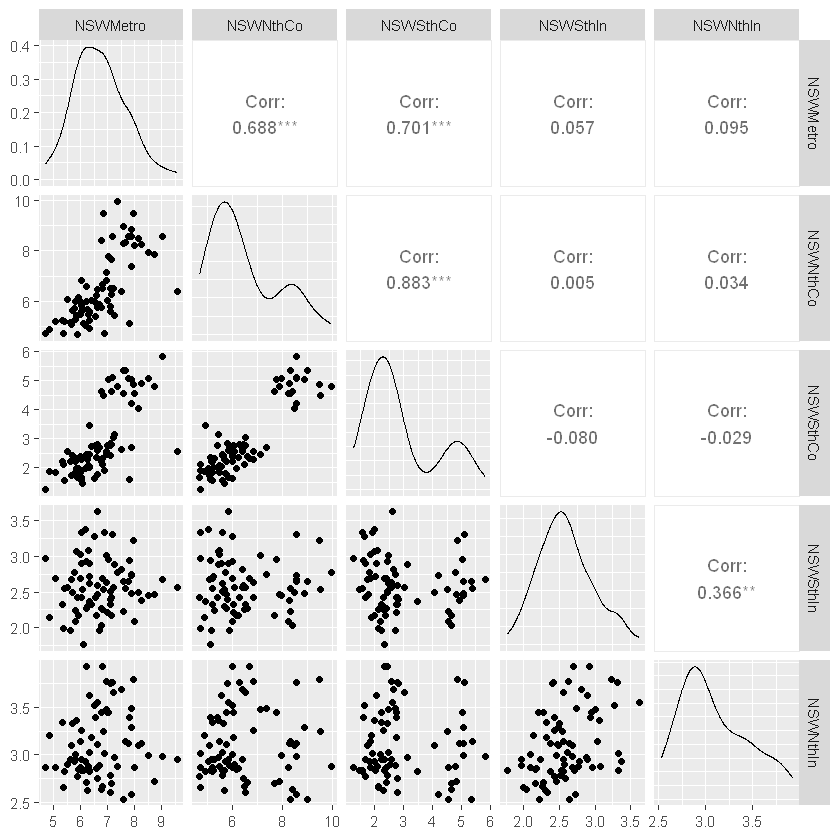

In [24]:
GGally::ggpairs(as.data.frame(visnights[,1:5]))

각 패널에서, 세로 축에 있는 변수는 그 해당하는 행의 변수 이름으로 주어지고, 가로 축에 있는 변수는 그 해당하는 열의 변수 이름으로 주어집니다. 각 패널 안에 다른 그래프를 나타낼 수 있는 여러 가지 방법이 있습니다. 기본값으로 주어진 것은, 그래프의 반쪽인 위쪽 오른편에는 상관관계(correlation)를 나타내고, 나머지 반쪽인 아래쪽 왼편에는 산점도(scatterplot)를 나타냅니다. 대각 성분에는 히스토그램(histogram) 또는 밀도 그래프(density plot)를 나타냅니다.

산점도행렬의 값은 모든 변수의 모든 관계를 빠르게 나타낼 수 있도록 합니다. 이 예제에서는, 두 번째 열에 있는 그래프는 NSW 북쪽 해안 방문객과 NSW 남쪽 해안 방문객 사이에 강한 양의 관계가 있다는 것을 보여줍니다만, NSW 북쪽 해안 방문객과 NSW 남부 내륙 방문 사이에는 주목할만한 관계가 없다는 것을 나타냅니다. 이상치도 보일 수 있습니다. NSW 광역 도시권에서 2000 시드니 올림픽과 관련하여 비정상적으로 높은 분기가 나타납니다. 이것을 그림 2.12 의 왼쪽 열에 있는 첫 2개 그래프에서 쉽게 관찰할 수 있습니다. 여기에서 NSW 광역 지역에 대한 가장 큰 값은 관측값의 무리에서 떨어져있습니다.

<br>

## 02.07. 시차 그래프

그림 2.13은 분기별 호주 맥주 생산량의 산점도(scatterplot)를 나타냅니다. 여기에서 가로축은 시계열의 시차값(lagged value)을 나타냅니다. 각 그래프는 서로 다른 $k$ 값에 대해서 $y_t$ (세로축)를 $y_{t−k}$(가로축)에 대해 나타낸 것입니다.

In [26]:
beer2 <- window(ausbeer, start=1992)
beer2

,Qtr1,Qtr2,Qtr3,Qtr4
1992,443,410,420,532
1993,433,421,410,512
1994,449,381,423,531
1995,426,408,416,520
1996,409,398,398,507
1997,432,398,406,526
1998,428,397,403,517
1999,435,383,424,521
2000,421,402,414,500
2001,451,380,416,492


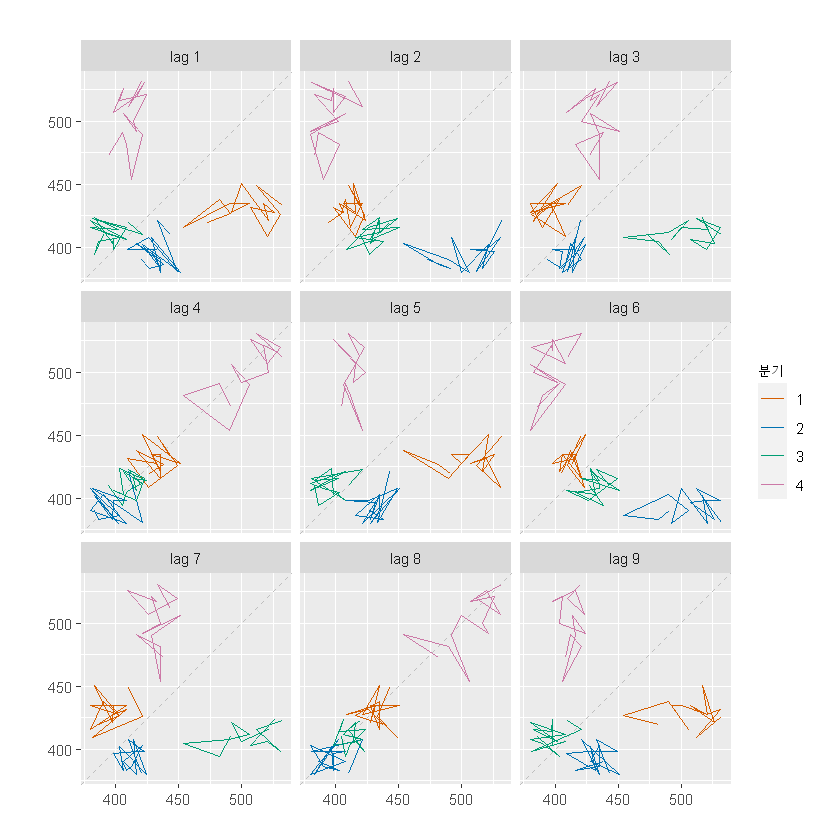

In [27]:
gglagplot(beer2) +
  guides(colour=guide_legend(title="분기")) +
  ggtitle("")

세로축($y_t$)의 범례에 있는 색상은 분기별 변수를 나타냅니다. **시차 4와 시차 8에서 양의 관계가 뚜렷합니다. 이는 데이터에 계절성이 강하게 있다는 것을 반영합니다.** **저점(2분기)에 대해 최고점(4분기)을 나타냈기 때문에 시차 2와 시차 6에서 음의 관계가 나타납니다.**

여기에서 사용한 window() 함수는 시계열의 부분을 뽑아낼 때 아주 유용합니다. 이 경우에, 1992년부터 시작하는 ausbeer에서 데이터를 가져왔습니다.

<br>

## 02.08. 자기상관

**상관값이 두 변수 사이의 선형 관계의 크기를 측정하는 것처럼, 자기상관(autocorrelation)은 시계열의 시차 값(lagged values) 사이의 선형 관계를 측정합니다.**

시차 그래프(lag plot)에서 각 패널과 관련된 몇 가지 자기상관 계수가 있습니다. 예를 들면, $r_1$은 $y_t$와 $y_{t-1}$사이의 관계를 측정하고, $r_2$는 $y_t$와 $y_{t−2}$사이의 관계를 측정하는 식입니다.

$r_k$값은 다음과 같이 쓸 수 있습니다.

$r_{k} = \frac{\sum\limits_{t=k+1}^T (y_{t}-\bar{y})(y_{t-k}-\bar{y})} {\sum\limits_{t=1}^T (y_{t}-\bar{y})^2},$

(여기에서 T는 시계열의 길이.)

<br>

- 분기별 맥주 생산량에 대한 자기상관함수.

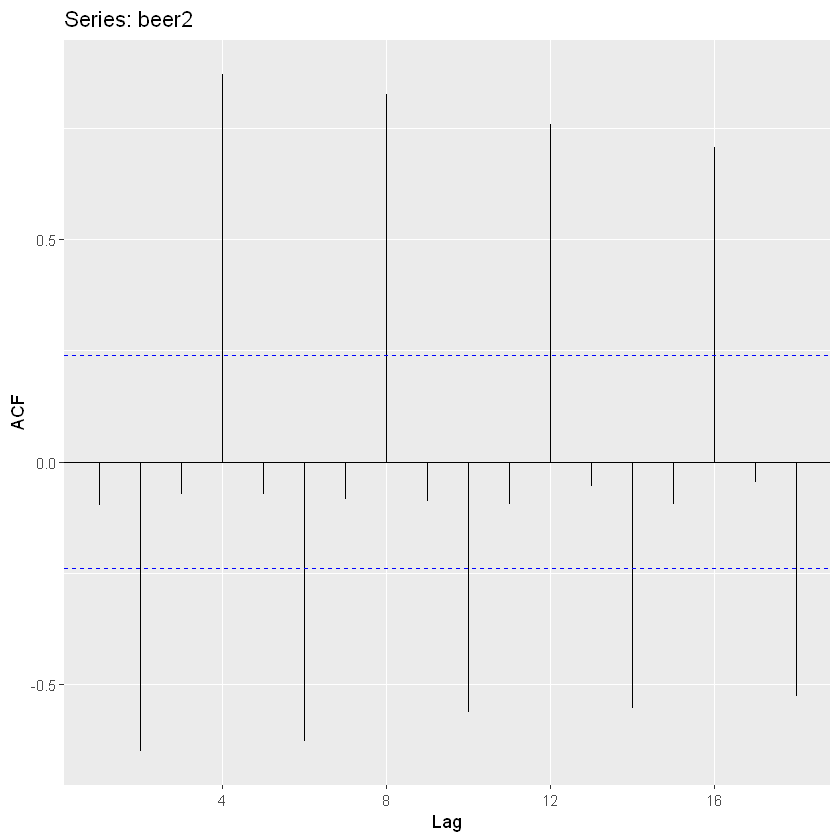

In [30]:
ggAcf(beer2)

이 그래프에서:

- $r_4$는 다른 시차들의 경우보다 값이 높은데, 이것은 데이터의 계절성 패턴 때문입니다: 고점은 4개의 분기마다 나타나는 경향이 있고, 마찬가지로 저점 역시 4개의 분기마다 나타나는 경향이 있습니다.
- $r_2$는 다른 시차들보다 더 큰 음의 값을 나타내는데, 왜냐하면 저점이 고점 직후의 2개 분기마다 나타나는 경향 때문입니다.
- **파란 점선은 상관계수가 0과 유의하게 다른지 아닌지를 나타냅니다**. 이러한 것을 2.9 절에서 설명합니다.

<br>

### ACF 그래프에서 추세와 계절성

**데이터에 추세가 존재할 때, 작은 크기의 시차에 대한 자기상관은 큰 양의 값을 갖는 경향이 있는데** 왜냐하면 시간적으로 가까운 관측치들이 관측값의 크기에 있어서도 비슷하기 때문입니다. **그래서 추세가 있는 시계열의 ACF는 양의 값을 갖는 경향이 보이며, 이러한 ACF의 값은 시차가 증가함에 따라 서서히 감소한다.**

**데이터에 계절성이 존재할 때의 자기상관은 다른 시차의 경우보다 계절성 시차(계절성 빈도의 배수로 나타나는)의 경우에 더 크게 나타날 것입니다.**

추세와 계절성을 모두를 나타내는 데이터의 경우에는 이들의 조합된 효과를 확인할 수 있습니다. 그림 2.15 의 호주 월별 전력 수요 시계열은 추세와 계절성 양쪽 모두를 나타냅니다. 이 시계열의 ACF은 그림 2.16 에 있습니다.

In [35]:
aelec <- window(elec, start=1980)
aelec

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1980,7366,7414,7824,7524,8279,8707,9486,8973,8231,8206,7927,7999
1981,7834,7521,8284,7999,8940,9381,10078,9796,8471,8572,8150,8168
1982,8166,7903,8606,8071,9178,9873,10476,9296,8818,8697,8381,8293
1983,7942,8001,8744,8397,9115,9773,10358,9849,9083,9143,8800,8741
1984,8492,8795,9354,8796,10072,10174,11326,10744,9806,9740,9373,9244
1985,9407,8827,9880,9364,10580,10899,11687,11280,10208,10212,9725,9721
1986,9846,9407,10265,9970,10801,11246,12167,11578,10645,10613,10104,10348
1987,10263,9973,10803,10409,11458,11845,12559,12070,11221,11338,10761,11012
1988,10923,10790,11427,10788,11772,12104,12634,12772,11764,11956,11646,11750
1989,11485,11198,12265,11704,12419,13259,13945,13839,12387,12546,12038,11977


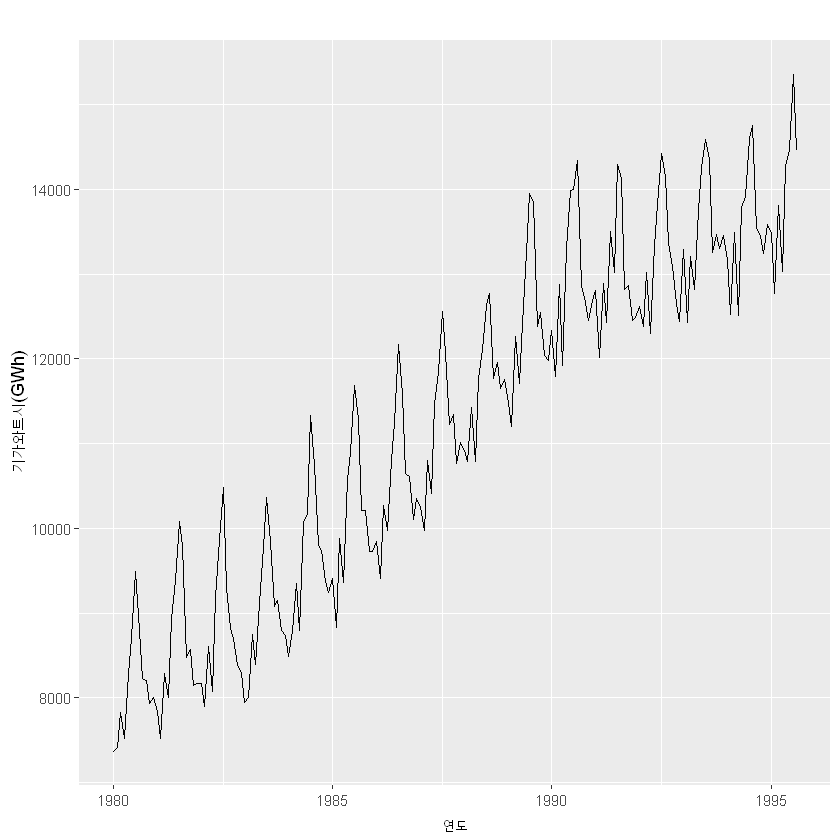

In [31]:
autoplot(aelec) + xlab("연도") + ylab("기가와트시(GWh)")

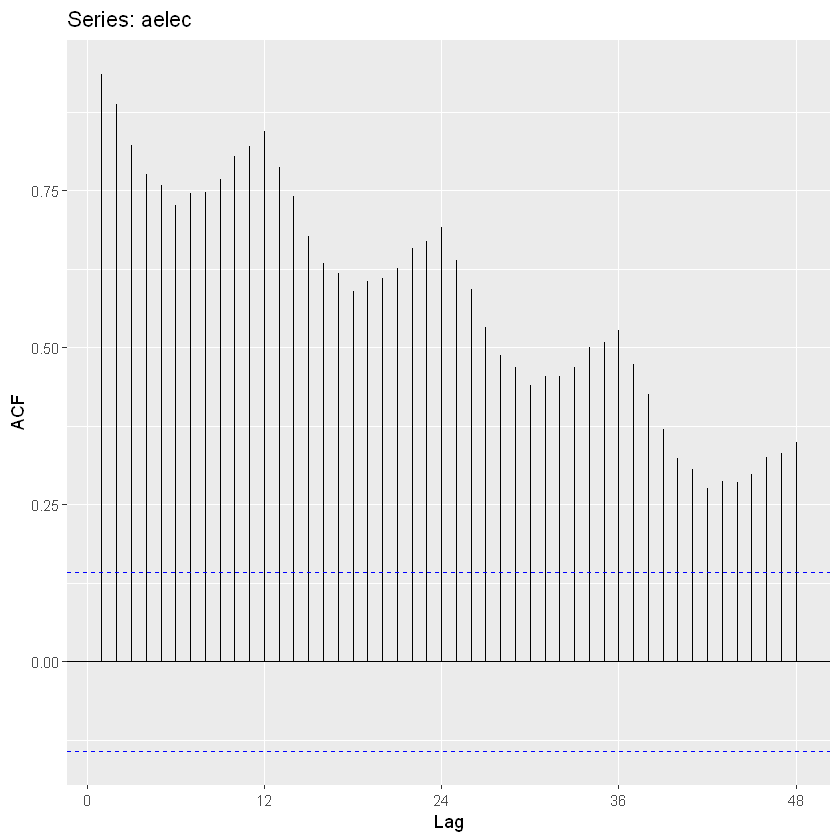

In [32]:
ggAcf(aelec, lag=48)

**시차값(lags)이 증가할수록 ACF 값이 서서히 감소하는 것은 추세 때문인 반면, “물결 모양(scalloped)”이 나타나는 것은 계절성 때문입니다.**

<br>

## 02.09. 백색잡음

**자기상관(autocorrelation)이 없는 시계열을 백색잡음(white noise)이라고 부릅니다.** 그림 2.17은 백색잡음 시계열의 예를 보여줍니다.

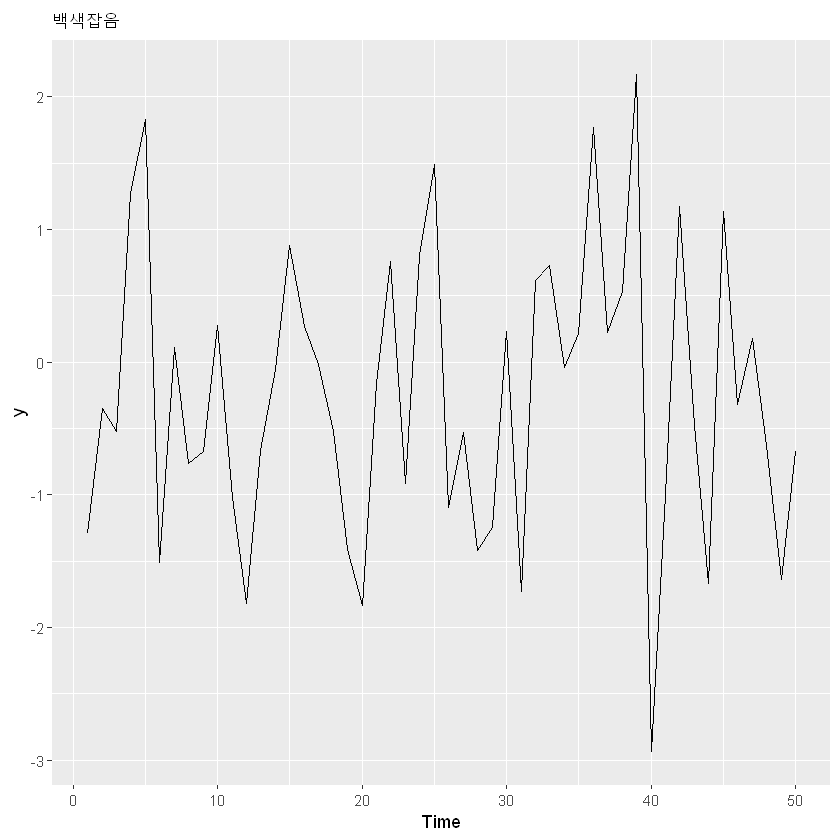

In [33]:
set.seed(30)
y <- ts(rnorm(50))
autoplot(y) + ggtitle("백색잡음")

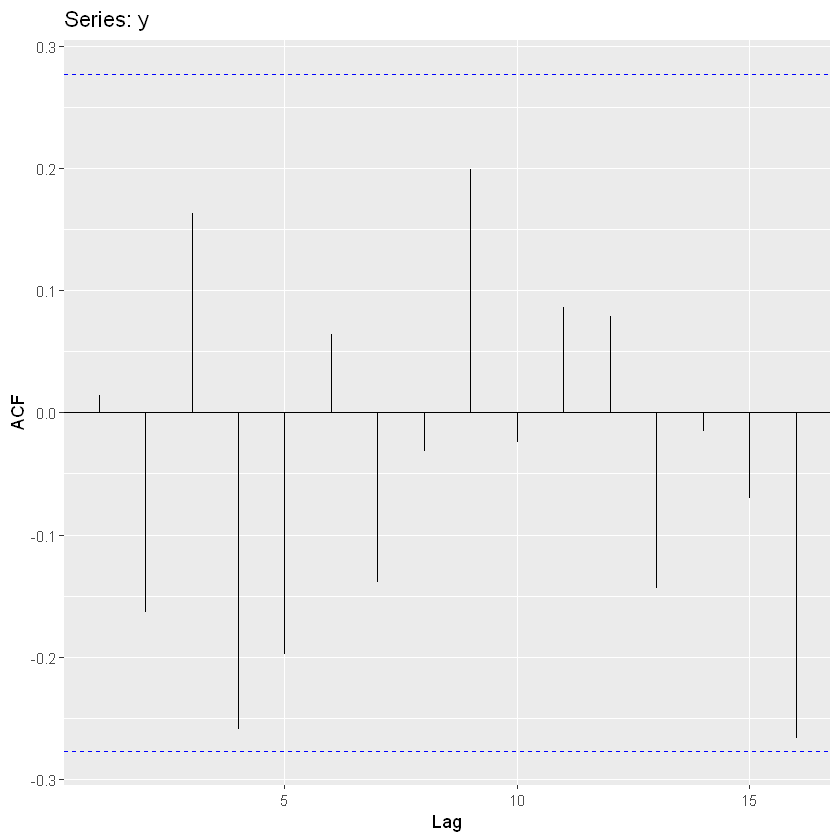

In [34]:
ggAcf(y)

백색잡음 시계열에 대해, 자기상관 값 각각이 거의 0일 것이라고 기대할 수 있습니다. 물론, 어떤 무작위적 변동 때문에 자기상관값이 정확하게 0은 아닐 것입니다. **백색잡음 시계열에 대해, ACF에서 뾰족한 막대의 95%가 $\pm 2/\sqrt{T}$에 들어갈 것이라고 기대할 수 있습니다.**

**여기에서 $T$는 시계열의 길이입니다. ACF의 그래프에서 이러한 경계를 주로 그래프로 그려서 나타냅니다(위의 파란 점선 경계). 하나 이상의 커다란 뾰족한 막대가 이러한 경계를 벗어나거나 뾰족한 막대의 5% 이상이 이러한 경계를 벗어난다면, 이러한 시계열은 아마도 백색잡음이 아닐 것입니다.**

이 예제에서는 $T=50$이라서 $\pm 2 / \sqrt{50} = \pm 0.28$에 경계가 있습니다. **자기상관 계수 전부가 이러한 한도 안에 들어가는 모습이 데이터가 백색잡음이라는 사실을 말해줍니다.**